# Statistics on PCMA

## Load libraries

In [1]:
from pyspark import SparkContext
import pyspark.sql.types as typ
import os
import re
import xlrd
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sc = SparkContext.getOrCreate()

## Create CSV files from original XLS PCMA spreadsheet

In [2]:
pcma_directory = "/Users/gverstra/Documents/PCMA/pcma-manual-config-master-3a24c3292530d2425a68e49b85c188cba8e5199a/spreadsheets"

In [32]:
pcma_with_jira = 0
pcma_without_jira = 0
pcmadict = {}
for file in os.listdir(pcma_directory):
    if not file.endswith("-old.xlsm"):
        #print(os.path.join(pcma_directory, file))
        x = re.match(r"OCACS-(\w*?)_", file)
        if x != None:
            #print("OCACS-" + x.group(1))
            jira = "OCACS-" + x.group(1)
            pcma_with_jira+=1
            #if jira in pcmadict:
            #    print(file)
            #    print(pcmadict[jira])
            pcmadict[jira] = file   # we keep the latest file listed
        else:
            pcma_without_jira+=1
print("Found {0} PCMA files with a JIRA issue".format(pcma_with_jira))
print("Found {0} PCMA files without a JIRA issue".format(pcma_without_jira))
print("Total of {0} PCMA files with a JIRA issue after removing duplicates".format(len(pcmadict)))
for jira in pcmadict:
    xlsfile = pcma_directory + "/" + pcmadict[jira]
    wb = xlrd.open_workbook(xlsfile)
    if 'OCC CP rack' in wb.sheet_names():
        sheet = wb.sheet_by_name('OCC CP rack')
    elif 'OCM CP rack' in wb.sheet_names():
        sheet = wb.sheet_by_name('OCM CP rack')
    csvfilename = pcma_directory + "/" + jira + ".csv"
    with open(csvfilename, 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"')
        for rownum in range(sheet.nrows):
            csvwriter.writerow(sheet.row_values(rownum))

Found 228 PCMA files with a JIRA issue
Found 15 PCMA files without a JIRA issue
Total of 192 PCMA files with a JIRA issue after removing duplicates


## Load PCMA files into RDD pcmas

In [44]:
pcmas = sc.wholeTextFiles(pcma_directory + "/*.csv")
pcmas.take(5)

[('file:/Users/gverstra/Documents/PCMA/pcma-manual-config-master-3a24c3292530d2425a68e49b85c188cba8e5199a/spreadsheets/OCACS-1026.csv',
  'Oracle Cloud Machine Platform Configuration Assistant,,,,,,,,,,,,,,,,, Version: 17.2.3-091117,\r\n,,,,,,,,,,,,,,,,,,\r\n,Customer Name,,,Beijing Navinfo Co Ltd ,,,,,,,Enter Customer Name,,,,,,,\r\n,,,,,,,,,,,,,,,,,,\r\n,Cloud Identifier,,,1576627.0,,,,,,,Enter the Subscription ID for the Oracle Cloud Machine Control Plane subscription (this is a 7-9 digit number).,,,,,,,\r\n,,,,,,,,,,,,,,,,,,\r\n,Country,,,China,,,,,,CN,"Enter the country this Oracle Cloud deployment will be part of. e.g. ""Australia"",""France"" (ISO 3166).",,,,,,,\r\n,,,,,,,,,,,,,,,,,,\r\n,Control Plane Identifier,,,1.0,,,,,,,"Enter the Control Plane identifier for the deployment, this is 1 in most cases.",,,,,,,\r\n,,,,,,,,,,,,,,,,,,\r\n,Domain ,,,<oracle specified>,,,s1576627.oraclecloudatcustomer.com,,,,"Oracle will deploy the Oracle Cloud utilizing an Oracle owned domain. As p

In [ ]:
pcmas = sc.wholeTextFiles(pcma_directory + "/OCACS-2489.csv")
pcmas.take(5)

## Filter data and load it into RDD filteredpcmas

In [45]:
def extractInfoFromPCMAcontent(pcma):
    # search JIRA
    x = re.search(r"file:/(.*)/(.*).csv", pcma[0])
    if x != None:
        jira = x[2]
    else:
        jira = ''
    # search Version
    x = re.search(r"(V|v)ersion: ([\d.\-]+),", pcma[1])
    if x != None:
        pcmaversion = x[2]
    else:
        x = re.search(r"[,+]Release: ([\d.\-]+),", pcma[1])
        if x != None:
            pcmaversion = x[1]
        else:
            pcmaversion = ''
    # search Customer Name
    x = re.search(r",Customer Name,,,(.*?),,,,,,,", pcma[1])
    if x != None:
        customername = x[1]
    else:
        x = re.search(r",Customer Name,(.*?),,,,,,,", pcma[1])
        if x != None:
            customername = x[1]
        else:
            customername = ''
    # search Number of OCC racks
    x = re.search(r"[,+]# of (OCM|OCC) racks including control plane,(\d+)", pcma[1])
    if x != None:
        numoccracks = int(x[2])
    else:
        numoccracks = -1
    # search Number of ExaCC racks
    x = re.search(r"[,+]# of (ExaCM|ExaCC) racks,(\d+)", pcma[1])
    if x != None:
        numexaccracks = int(x[2])
    else:
        numexaccracks = -1
    # search Port type on upstream router
    x = re.search(r"[,+]Port type on the upstream router\(s\),(.*?),,,Port type:", pcma[1])
    if x != None:
        upstreamporttype = x[1]
    else:
        #,,,Port speed on the upstream switch/router(s),10Gbps,Port type: 
        x = re.search(r"[,+]Port speed on the upstream switch\/router\(s\),(.*?),Port type:", pcma[1])
        if x != None:
            upstreamporttype = x[1]
        else:
            upstreamporttype = ""
    # search Number of ports on the upstream router
    x = re.search(r"[,+](Number of|Total) ports (on|connected to) the upstream (switch/)?router\(s\),(\d+)", pcma[1])
    if x != None:
        numupstreamports = int(x[4])
    else:
        numupstreamports = 0
    # search Port Channeling type
    x = re.search(r",Upstream router Port Config Type,,,(.*),,,,,,,\"If link", pcma[1])
    if x != None:
        portchanneling = x[1]
    else:
        x = re.search(r",Router pair #,Label,Port (c|C)hanneling,MTU,Target networks,Customer-side BGP ASN,BGP keepalive/holdtime([,]+?)\r\n,1,(.*?),(.*?),", pcma[1])
        if x != None:
            portchanneling = x[4]
        else:
            x = re.search(r",Router pair #,Label,Port (c|C)hanneling,MTU,Customer-side BGP ASN,BGP keepalive/holdtime([,]+?)\r\n,1,(.*?),(.*?),", pcma[1])
            if x != None:
                portchanneling = x[4]
            else:
                portchanneling = ""
    # search num Upstream router
    x = re.search(r"[,+]Total number of upstream router pairs,(\d+).0[,+]", pcma[1])
    if x != None:
        numrouters = int(x[1])
    else:
        numrouters = -1
    # search routing protocol
    x = re.search(r"[,+]Routing protocol,(.*?)[,+]", pcma[1])
    if x != None:
        routingprotocol = x[1]
    else:
        routingprotocol = ""
    return (jira, 
            pcmaversion, 
            customername, 
            numoccracks, 
            numexaccracks, 
            upstreamporttype, 
            numupstreamports, 
            portchanneling, 
            numrouters, 
            routingprotocol
           )

filteredpcmas = pcmas.map(extractInfoFromPCMAcontent)
filteredpcmas.take(2)

[('OCACS-1026',
  '17.2.3-091117',
  'Beijing Navinfo Co Ltd ',
  1,
  0,
  '10Gbps',
  16,
  'No link aggregation',
  -1,
  ''),
 ('OCACS-1057',
  '17.2.3-091117',
  'AI Inversiones Palo Alto II S.A.C.',
  1,
  0,
  '10Gbps',
  8,
  '2 Link Aggregation Groups',
  -1,
  '')]

## Cleanup data into RDD cleanpcmas

In [53]:
def cleanDataFromFilteredPCMA(pcma):
    jira = pcma[0]
    pcmaversion = pcma[1]
    customername = pcma[2]
    numoccracks = pcma[3]
    numexaccracks = pcma[4]
    upstreamporttype = pcma[5]
    numupstreamports = pcma[6]
    portchanneling = pcma[7]
    numrouters = pcma[8]
    routingprotocol = pcma[9]

    if portchanneling == "2 Link Aggregation Groups":
        portchanneling = "Per-Chassis LAG"
    if portchanneling == "cross-chassis LAG":
        portchanneling = "Multi-Chassis LAG"
    if routingprotocol == "":
        routingprotocol = "no choice"
    if numexaccracks == -1:
        numexaccracks = 0
    return (jira, 
            pcmaversion, 
            customername, 
            numoccracks, 
            numexaccracks, 
            upstreamporttype, 
            numupstreamports, 
            portchanneling, 
            numrouters, 
            routingprotocol
           )

cleanpcmas = filteredpcmas.map(cleanDataFromFilteredPCMA)
cleanpcmas.take(1)

[('OCACS-1026',
  '17.2.3-091117',
  'Beijing Navinfo Co Ltd ',
  1,
  0,
  '10Gbps',
  16,
  'No link aggregation',
  -1,
  'no choice')]

## Reduce from the RDD

### count PCMA by version

In [47]:
d = cleanpcmas.map(lambda x : (x[1], list(x[:1]) + list(x[2:]))).countByKey()
pd.DataFrame(list(d.items()), columns=['pcmaversion', 'count'])

,pcmaversion,count
0,17.2.3-091117,63
1,17.4.2-121817,1
2,17.2.3-081017,30
3,17.4.2-011818,18
4,17.4.2-121217,5
5,17.4.2-010818,5
6,17.4.2-020118,34
7,20180322,29
8,20180321,7


### Count PCMA by Upstream port type

In [15]:
d = cleanpcmas.map(lambda x : (x[5], list(x[:5]) + list(x[6:]))).countByKey()
pd.DataFrame(list(d.items()), columns=['upstreamporttype', 'count'])

,upstreamporttype,count
0,10Gbps,159
1,40Gbps,33


### Count PCMA by port channeling type

In [8]:
d = cleanpcmas.map(lambda x : (x[7], list(x[:7]) + list(x[8:]))).countByKey()
pd.DataFrame(list(d.items()), columns=['portchannelingtype', 'count'])

,portchannelingtype,count
0,No link aggregation,72
1,Per-Chassis LAG,74
2,Multi-Chassis LAG,46


## Reduce from a Dataframe

### Create a dataframe out of RDD filteredpcmas

In [54]:
schema = [
    ('jira', typ.StringType()),
    ('pcmaversion', typ.StringType()),
    ('customername', typ.StringType()),
    ('numoccracks', typ.IntegerType()),
    ('numexaccracks', typ.IntegerType()),
    ('upstreamporttype', typ.StringType()),
    ('numupstreamports', typ.IntegerType()),
    ('portchanneling', typ.StringType()),
    ('numrouters', typ.IntegerType()), 
    ('routingprotocol', typ.StringType())
]
schema = typ.StructType([typ.StructField(e[0],e[1],True) for e in schema])

pcmadf = spark.createDataFrame(cleanpcmas, schema)
pcmadf.createOrReplaceTempView("pcmas")
pcmadf.count()

192

### Count PCMA by version

,pcmaversion,count
0,20180322,29
1,17.4.2-010818,5
2,17.2.3-091117,63
3,17.4.2-121817,1
4,17.4.2-121217,5
5,17.2.3-081017,30
6,17.4.2-011818,18
7,20180321,7
8,17.4.2-020118,34


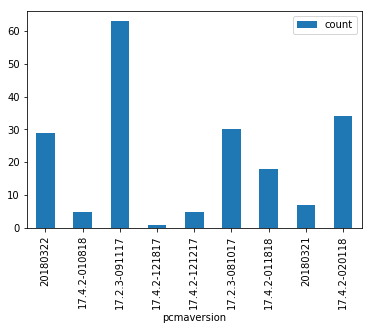

In [18]:
pdf = spark.sql("select pcmaversion,count(*) as count from pcmas group by pcmaversion").toPandas()
pdf.plot(kind='bar',x='pcmaversion')
pdf

### Count PCMA by Upstream port type

,upstreamporttype,count
0,10Gbps,159
1,40Gbps,33


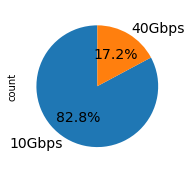

In [19]:
pdf = spark.sql("select upstreamporttype, count(*) as count from pcmas group by upstreamporttype").toPandas()
ax1 = plt.subplot(121, aspect='equal')
pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf['upstreamporttype'], legend = False, fontsize=14)
pdf

## count by port channeling type

,portchanneling,count
0,No link aggregation,72
1,Multi-Chassis LAG,46
2,Per-Chassis LAG,74


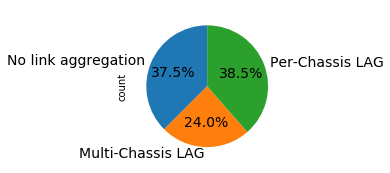

In [20]:
pdf = spark.sql("select portchanneling,count(*) as count from pcmas group by portchanneling").toPandas()
#pdf.plot(kind='bar',x='portchanneling')
ax1 = plt.subplot(121, aspect='equal')
pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf['portchanneling'], legend = False, fontsize=14)
pdf

## count by Routing protocol

,routingprotocol,count
0,no choice,93
1,BGP,6
2,static,93


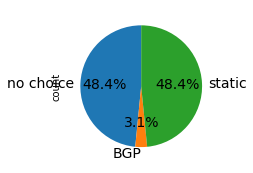

In [13]:
pdf = spark.sql("select routingprotocol,count(*) as count from pcmas group by routingprotocol").toPandas()
ax1 = plt.subplot(121, aspect='equal')
pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf['routingprotocol'], legend = False, fontsize=14)
pdf

## Count by number of upstream router (-1 means that there was no choice to select multiple upstream routers)

,numrouters,count
0,-1,93
1,1,75
2,2,15
3,3,3
4,4,3
5,5,1
6,6,1
7,7,1


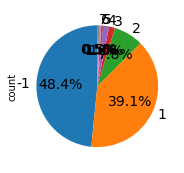

In [50]:
pdf = spark.sql("select numrouters,count(*) as count from pcmas group by numrouters order by numrouters").toPandas()
ax1 = plt.subplot(121, aspect='equal')
pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf['numrouters'], legend = False, fontsize=14)
pdf

## count by number of ExaCC racks

,numexaccracks,count
0,0,61
1,1,97
2,2,22
3,3,8
4,5,4


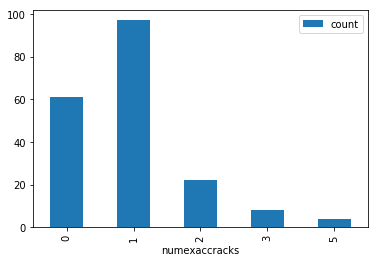

In [21]:
pdf = spark.sql("select numexaccracks,count(*) as count from pcmas group by numexaccracks order by numexaccracks").toPandas()
pdf.plot(kind='bar',x='numexaccracks')
pdf